# Problem

I used to be an actuary so my financial future is of big concern to me. I was recently really disappointed in the return of my investments and felt somewhat powerless because I don't know much about investing. I know about how much I'm going to need for my retirement, but not the details of how to get there. Being an hands-on guy I figured I could use this Project 5 opportunity to learn more about finance and see if my knowledge of machine learning can help me save on commission and make better decisions on my own. Understanding what has a significant impact on one's life is important not only to me but to everyone. If I can help those around me, my wife, my family and my friends with their investments decisions why not take a shot at it. 

# Solution

This is a **prediction** problem. I want to know what will be the return of an investment in the future. What will be the return over a certain period of time so I can issue a Buy or Sell order. This is not about building a diverse portfolio but rather a tool to help build it. Building the portfolio will be the next step after this project.

This could be a classification problem if I was trying to issue a Buy or Sell order, but here I want to output the return value and not an action. 

The predictions will need to be as precise as possible. Underestimating or overestimating the return of a stock will necessarily mean that the Buy/Sell decisions won't be as informed as possible. It will of course not be possible to be 100% accurate, but I think that within 5% is good enough. So if the true return is 10% then if I predict between 9.5% and 10.5% the algorithm is good enough. I don't expect such precision if the prediction is too far in the future. The further it is in the future, the less certain our predictions will be. So 5% for a 7 day forecast is my goal.


### Approach

- Two algorithms will be mainly expolored, support vector regression (SVR) and kNN.
    - I expect the returns (the object of our prediction) to be somewhat chaotic given the features I will use. kNN is a good choice for that
    - SVR is also very adaptable because of its kernel trick so it could adapt to this anticipated chaotic landscape.
- Training and testing set size will be 70/30 split in time. The testing set will be after the training set so we are not peeking into the future when training
- GridSearch will be used with Mean Squared Error (MSE) as a minimization metric. I want the model to fit as best as possible the large values of stock price changes
- Bagging will be used as well because it is less prone to overfitting. It will take the mean of every model so the overfitting will be smoothed out.
- The speed requirements for training is not that great for the current problem. I am not dealing in High Frequency Trading. A human will take a short (few days) to mid (few weeks) term decision based on the predictions.

#### Features

Many features could be interesting such as P/E Ratio and Ebitda, but those informations only come out every quarter and I'm looking at features than changes at least every day like the following:
- Volume
- Adjusted Close
- Adjusted High
- Adjusted Low
- Adjusted Open
- 10 day rolling mean and 
- 10 day rolling standard deviation (for the [Bollinger Bands](https://en.wikipedia.org/wiki/Bollinger_Bands))
- S&P500 index

#### Target
- Return over X days $\left(\frac{price_{t+x}}{price_{t}} - 1\right)$

#### Data Source
- Quandl API
- Yahoo Finance

### Package Requirements
- numpy:           1.10.2
- pandas:          0.17.1
- python-dateutil: 2.4.2
- pytz:            2015.7
- quandl:          2.8.9
- requests:        2.9.0
- six:             1.10.0
- scikit-learn:    0.17
- scipy:           0.16.1

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from predictor import SVRPredictor, Stock, KNNPredictor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

/Users/alexis/anaconda/envs/MLND/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### SVR

In [3]:
svr = SVRPredictor(['AAPL'], 7)
svr.fit(start_date='2015-01-01', end_date='2015-10-31')

                Open      High       Low    Volume  Adjusted Close  SP Close  \
Date                                                                           
2015-01-02  0.825168  0.825048  0.810375  0.328006        0.818223  0.965919   
2015-01-05  0.802204  0.804392  0.795730  0.396319        0.795172  0.948264   
2015-01-06  0.789240  0.795360  0.789842  0.405638        0.795247  0.939831   
2015-01-07  0.794129  0.801060  0.805468  0.247252        0.806398  0.950761   
2015-01-08  0.809167  0.830304  0.820566  0.365981        0.837382  0.967768   

                 ATR  r_mean10   r_std10  
Date                                      
2015-01-02  0.011224  0.839739  0.010833  
2015-01-05  0.012439  0.834949  0.017644  
2015-01-06  0.012178  0.830818  0.021615  
2015-01-07  0.011327  0.826934  0.022217  
2015-01-08  0.012092  0.826448  0.021896  


In [4]:
svr.models['AAPL']

SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=1e-05, gamma='auto',
  kernel='linear', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [5]:
predictions = svr.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')

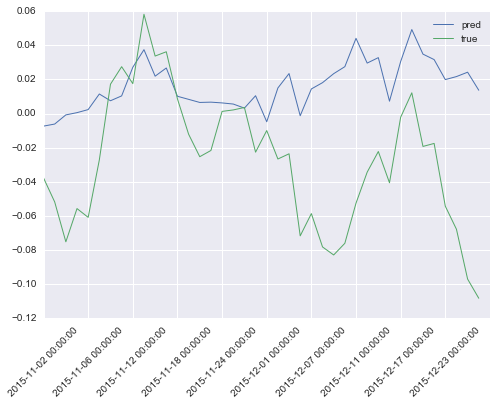

In [6]:
y_pred, y_true = predictions['AAPL']
plt.plot(range(0,len(y_pred)), y_pred, linewidth=1)
plt.plot(range(0,len(predictions['AAPL'][1])), predictions['AAPL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
# plt.plot(range(0,len(y_pred)), np.array(y_pred) - np.array(y_test), linewidth=1)
plt.legend(['pred', 'true'])

In [7]:
((y_pred-y_true)**2).mean()**0.5

0.058527164543821536

### kNN

In [7]:
knn = KNNPredictor(['AAPL'], 7)
knn.fit(start_date='2015-01-01', end_date='2015-10-31')

                Open      High       Low    Volume  Adjusted Close  SP Close  \
Date                                                                           
2015-01-02  0.825168  0.825048  0.810375  0.328006        0.818223  0.965919   
2015-01-05  0.802204  0.804392  0.795730  0.396319        0.795172  0.948264   
2015-01-06  0.789240  0.795360  0.789842  0.405638        0.795247  0.939831   
2015-01-07  0.794129  0.801060  0.805468  0.247252        0.806398  0.950761   
2015-01-08  0.809167  0.830304  0.820566  0.365981        0.837382  0.967768   

            r_mean10   r_std10  
Date                            
2015-01-02  0.839739  0.010833  
2015-01-05  0.834949  0.017644  
2015-01-06  0.830818  0.021615  
2015-01-07  0.826934  0.022217  
2015-01-08  0.826448  0.021896  


In [8]:
knn.models['AAPL']

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=15, p=2,
          weights='uniform')

In [9]:
predictions = knn.transform(['AAPL'], start_date='2015-11-01', end_date='2015-12-31')

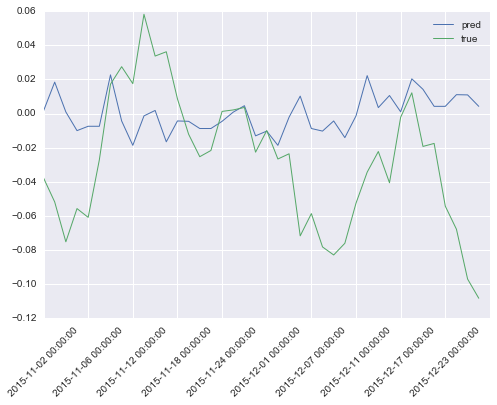

In [10]:
y_pred, y_true = predictions['AAPL']
plt.plot(range(0,len(y_pred)), y_pred, linewidth=1)
plt.plot(range(0,len(predictions['AAPL'][1])), predictions['AAPL'][1], linewidth=1)
plt.xticks(4*np.arange(len(y_pred)/4), y_pred.index[::4], rotation=45)
# plt.plot(range(0,len(y_pred)), np.array(y_pred) - np.array(y_test), linewidth=1)
plt.legend(['pred', 'true'])

In [11]:
((y_pred-y_true)**2).mean()**0.5

0.04931214856366075

In [ ]:
stock = Stock(['AAPL'])

In [ ]:
data, label = stock.get_data(start_date='2015-11-01', end_date='2015-12-31', fit=True)

In [ ]:
data.head()

In [ ]:
df = pd.read_csv("d2015-11-01_2015-12-31.csv", index_col=0, parse_dates='Date')

In [ ]:
df['2015-11-01':'2015-12-31'].max()

In [ ]:
df['2015-11-01':'2015-12-31'].head()

In [ ]:
df['2015-11-01':'2015-12-31']

In [14]:
DataFrame.apply?

In [13]:
from pandas import DataFrame